# Μέρος 1ο - Μικρό Dataset

In [1]:
# Φορτώνουμε τα δεδομένα του μικρού dataset

import numpy as np

github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"

dataset = "graves/ring_noisy" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

!wget $data_url
!wget $labels_url

# load data into a numpy array
X = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)

# Load the corresponding reference labels. The original labels are in {1,2,..,k}.
# We'll make them more Python-ish by subtracting 1.
y  = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc)-1

# The number of unique labels gives the true cluster count:
num_clusters = len(np.unique(y))

--2021-12-19 16:35:20--  https://github.com/gagolews/clustering_benchmarks_v1/raw/master/graves/ring_noisy.data.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/graves/ring_noisy.data.gz [following]
--2021-12-19 16:35:20--  https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/graves/ring_noisy.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14845 (14K) [application/octet-stream]
Saving to: 'ring_noisy.data.gz.34'

     0K .......... ....                                       100%  351K=0.04s

2021-12-19 16:35:20 (351 KB/s) 

In [2]:
# Οι διαστάσεις των δεδομένων και τα Clusters

print('The dimensions of the small dataset are: ', X.shape)
print('The unique clusters are:', num_clusters)

The dimensions of the small dataset are:  (1050, 2)
The unique clusters are: 3


In [3]:
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

start_time = time.time()

# Κατασκευάζουμε κάποιες συναρτήσεις που 
# θα χρειαστούμε παρακάτω

def evaluate_metrics(model,X, y, clusters, model_name, linkage = None):
    import time
    global start_time
    if linkage == None: # No HAC
        start_time = time.time() # tic (predict+fit time)
        model.fit(X)
        y_pred = model.predict(X)
        time = round(time.time() - start_time,6) # tac
        
        # Evaluate metrics
        ARI = round(metrics.adjusted_rand_score(y, y_pred),5)
        AMI = round(metrics.adjusted_mutual_info_score(y, y_pred),5)
        Vm = round(metrics.v_measure_score(y, y_pred),5)
        
        return ([model_name, ARI, AMI, Vm, time], y_pred) # return a tuple of (results, y_pred)
    
    else: # HAC clustering, different attributes for fit
        #from scipy.cluster.hierarchy import fcluster
        
        start_time = time.time() # tic
        y_pred = fcluster(model, clusters, criterion='maxclust')
        time = round(time.time() - start_time, 6) # tac
        
        # Evaluate metrics
        ARI = round(metrics.adjusted_rand_score(y, y_pred),5)
        AMI = round(metrics.adjusted_mutual_info_score(y, y_pred),5)
        Vm = round(metrics.v_measure_score(y, y_pred),5)
        
        return ([model_name +', linkage=' + linkage, ARI, AMI, Vm, time], y_pred) # Again tuple of (results , y_pred)

def plot_clusters(y, y_pred, model_name):

    fig, ax = plt.subplots(nrows =1, ncols =2, figsize=(15,5), sharey = True)

    ax[0].scatter(X[:,0], X[:,1], c = y_pred) # Prediction
    ax[0].set_ylabel('Feature 2')
    ax[0].set_title(model_name + " (prediction)")
    ax[0].set_xlabel('Feature 1')


    ax[1].scatter(X[:,0], X[:,1], c = y) # True clusters
    ax[1].set_title('True Clusters')
    ax[1].set_xlabel('Feature 1')
    
    plt.show()
    

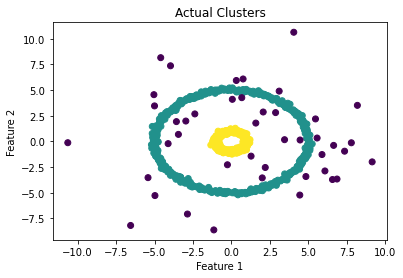

In [4]:
# Η αναπαράσταση των δεδομένων

plt.scatter(X[:,0], X[:,1], c = y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Actual Clusters')
plt.show()

# 1.1 KMeans Implementation

In [5]:
# Υλοποίηση KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters = num_clusters, random_state = 10) # set random_state to have same results for all runs
results, y_pred = list(evaluate_metrics(model, X, y,clusters = num_clusters, model_name = 'KMeans'))


In [6]:
# Create a DataFrame to keep the results
result_small = pd.DataFrame(results, index =['Algorithm', 'AdjustedRandIndex', 'AMInformation', 'V-measure', 'Time']).T

result_small

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125


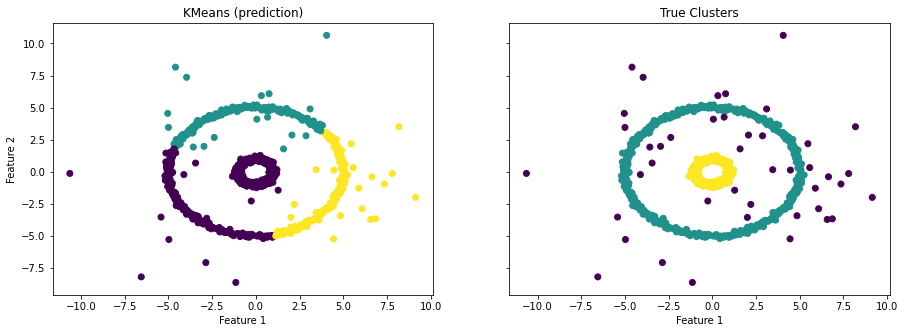

In [7]:
# KMeans clusters vs Actual clusters

plot_clusters(y, y_pred, 'KMeans')

Όπως βλέπουμε και απ'τα διαγράμμα διασποράς ο KMeans αδυνατεί να αναγνωρίση τον θόρυβο που υπάρχει στα δεδομένα (τα μοβ σημεία στο δεξί σχήμα). Επίσης, αναμένουμε απ'τον KMeans να μη μπορεί να αποκωδικοποιήσει ποτέ πλήρως τα κανονικά Clusters καθώς αυτά είναι μη κυρτά υποσύνολα του $\mathbb{R}^2$ και ο KMeans δε μπορεί να κάνει καλές προβλέψεις για μη κυρτά σύνολα.

# 1.2 HAC Implementation

# 1.2.1 Σύνδεσμος 'single'

In [8]:
# Υλοποίηση HAC
import fastcluster 

model = fastcluster.linkage(X, method = 'single') # HAC with linkage = 'single'

results, y_pred = evaluate_metrics(model, X, y, num_clusters, model_name = 'HAC', linkage = 'single')

In [9]:
result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

In [10]:
result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001


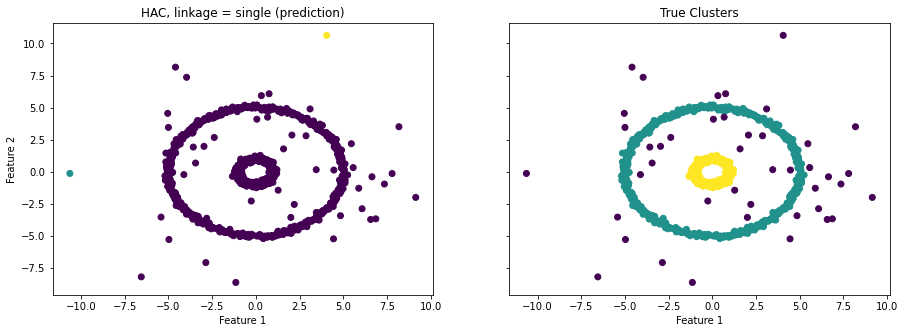

In [11]:
plot_clusters(y, y_pred, 'HAC, linkage = single')

Όπως βλέπουμε ο ιεραρχικός συσσωρευτικός αλγόριθμος συσταδοποίησης με σύνδεσμο single δε μπορεί να διακρίνει τα τρία clusters. Αυτό οφείλεται στο γεγονός ότι με τον σύνδεσμο single ο αλγόριθμος ακολουθώντας τη ιεραρχία «bottom-up» ενώνει τα δύο Clusters $C_1,\,C_2$ σύμφωνα με τον εξής κανόνα
$$C_1\quad\text{links with}\quad C_2 \Longleftrightarrow d(C_1,\,C_2)\leq d(C_1, C_j)\quad \text{για κάθε}\, j\neq 1,2,$$
όπου
$$ d(C_i,\,C_j)=\min\{||\alpha - \beta||_2:\, \alpha\in C_i,\, \beta\in C_j\}.$$
Εδώ με $||\cdot||_2$ συμβολίζουμε την Ευκλείδεια νόρμα η οποία είναι και η default απόσταση που χρησιμοποιεί ο αλγόριθμος. Όπως βλέπουμε και απ'το διάγραμμα διασποράς τα δύο σημεία που έχουν χρωματιστεί με μπλε και κίτρινο απέχουν πολύ μακριά απ'τα άλλα σημεία με αποτέλεσμα να διαμορφώνουν ένα Cluster από μόνα τους, ενώ τα υπόλοιπα μπάινουν όλα μαζί σε ένα Cluster. Παρακάτω βλέπουμε και τα Clusters που δημιουργούνται χρησιμοποιώντας και άλλες αποστάσεις πέρα απ'την Ευκλείδεια.

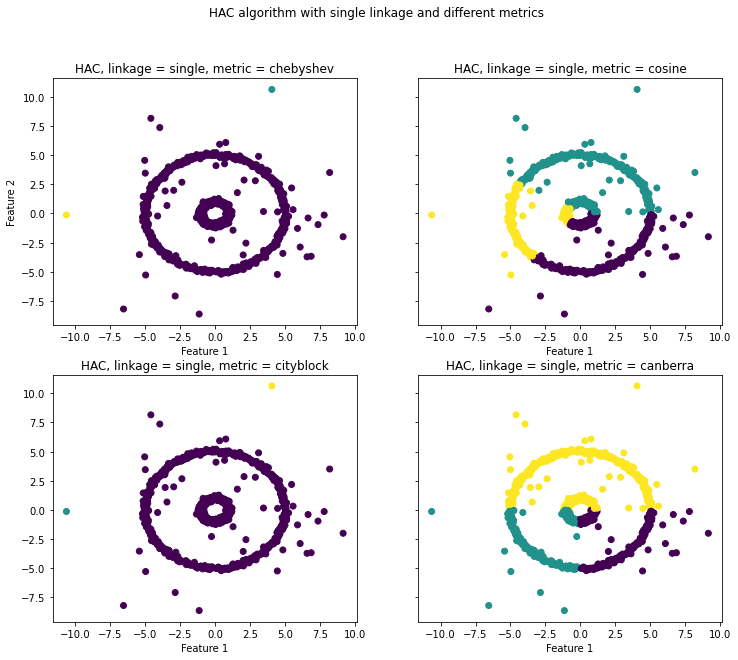

In [12]:
# Μερικά διαγράμματα διασποράς για διαφορετικές μετρικές

fig, ax = plt.subplots(nrows =2, ncols =2, figsize=(12,10), sharey = True)

model1 = fastcluster.linkage(X, method = 'single', metric = 'chebyshev')
y_pred1 = fcluster(model1, num_clusters, criterion='maxclust')

ax[0][0].scatter(X[:,0], X[:,1], c = y_pred1) # chebyshev
ax[0][0].set_ylabel('Feature 2')
ax[0][0].set_title('HAC, linkage = single, metric = chebyshev')
ax[0][0].set_xlabel('Feature 1')

model2 = fastcluster.linkage(X, method = 'single', metric = 'cosine')
y_pred2 = fcluster(model2, num_clusters, criterion='maxclust')

ax[0][1].scatter(X[:,0], X[:,1], c = y_pred2) # cosine
ax[0][1].set_title('HAC, linkage = single, metric = cosine')
ax[0][1].set_xlabel('Feature 1')

model3 = fastcluster.linkage(X, method = 'single', metric = 'cityblock')
y_pred3 = fcluster(model3, num_clusters, criterion='maxclust')

ax[1][0].scatter(X[:,0], X[:,1], c = y_pred3) # cityblock
ax[1][0].set_title('HAC, linkage = single, metric = cityblock')
ax[1][0].set_xlabel('Feature 1')

model4 = fastcluster.linkage(X, method = 'single', metric = 'canberra')
y_pred4 = fcluster(model4, num_clusters, criterion='maxclust')

ax[1][1].scatter(X[:,0], X[:,1], c = y_pred4) # canberra
ax[1][1].set_title('HAC, linkage = single, metric = canberra')
ax[1][1].set_xlabel('Feature 1')

fig.suptitle('HAC algorithm with single linkage and different metrics')
plt.show()

Απ'τα παραπάνω διαγράμματα διασποράς βλέπουμε ότι οι αλγόριθμοι που χρησιμοποιούν τις μετρικές canberra και cosine πετυχαίνουν καλύτερο clustering απ'αυτές που χρησιμοποιούν τις cityblock και chebyshev. Συνεπώς, στο συγκεκριμένο πρόβλημα αναμένουμε να έχουμε καλύτερες επιδόσεις ως προς αυτές τις δύο μετρικές. Παρ'ολα αυτά επειδή σε πραγματικά προβλήματα δε γνωρίζουμε τα labels δε μπορούμε να ξέρουμε ποια είναι η πραγματική κατηγοριοποίηση. Για την τελική σύγκριση χρησιμοποιούμε τους αλγορίθμους που χρησιμοποιούν την Ευκλείδεια απόσταση.

# 1.2.2 Σύνδεσμος 'average'

In [13]:
# HAC with linkage = average
model = fastcluster.linkage(X, method = 'average')

results, y_pred = evaluate_metrics(model, X, y, num_clusters, model_name = 'HAC', linkage = 'average')

In [14]:
# Update our DataFrame with results

result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898


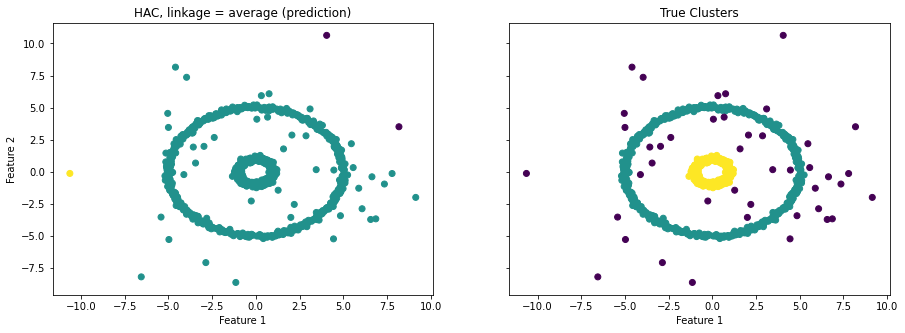

In [15]:
plot_clusters(y, y_pred, 'HAC, linkage = average')

Όπως και στην περίπτωση με σύνδεσμο single έτσι και ο HAC με σύνδεσμο average δε μπορεί να αποκωδικοποίηση την πραγματική σχέση των δεδομένων όπως φαίνεται και απ'τα παραπάνω διαγράμματα.

# 1.2.3 Σύνδεσμος 'complete'

In [16]:
# HAC with linkage = complete

model = fastcluster.linkage(X, method = 'complete')

results, y_pred = evaluate_metrics(model, X, y, num_clusters, model_name = 'HAC', linkage = 'complete')

In [17]:
# Update our DataFrame with results

result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898
0,"HAC, linkage=complete",0.33031,0.35743,0.35901,0.002001


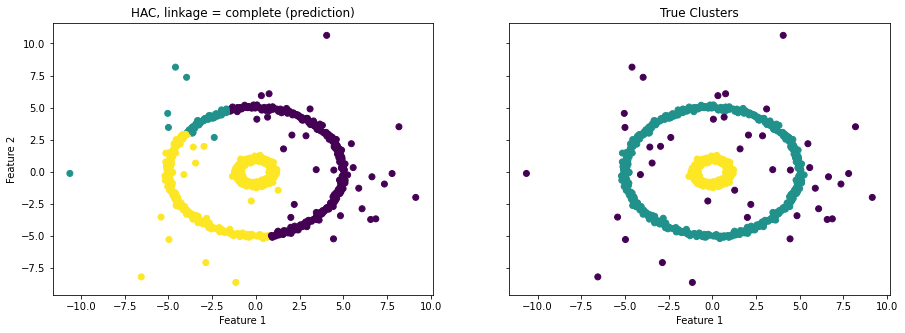

In [18]:
plot_clusters(y, y_pred, 'HAC, linkage = complete')

Σε αντίθεση με τον σύνδεσμο single ο σύνδεσμος complete χρησιμοποιεί τη μέγιστη απόσταση χρησιμοποιεί τις μέγιστες αποστάσεις μεταξύ όλων των παρατηρήσεων των δύο συνόλων. Όπως φαίνεται και απ'τα παραπάνω διαγράμματα αυτός ο σύνδεσμος πετυχαίνει ερμήνεια μια ερμηνεία των δεδομένων που είναι πιο κοντά στην πραγματική σε σχέση με τους δύο προηγούμενους συνδέσμους. Αυτό φαίνεται και απ'τις τιμές των μετρικών στο παραπάνω DataFrame.

# 1.2.4 Σύνδεσμος 'Ward'

In [19]:
# HAC with linkage = ward
model = fastcluster.linkage(X, method = 'ward')

results, y_pred = evaluate_metrics(model, X, y, num_clusters, model_name = 'HAC', linkage = 'ward')

In [20]:
# Update our DataFrame with results

result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898
0,"HAC, linkage=complete",0.33031,0.35743,0.35901,0.002001
0,"HAC, linkage=ward",0.42839,0.4357,0.43692,0.003011


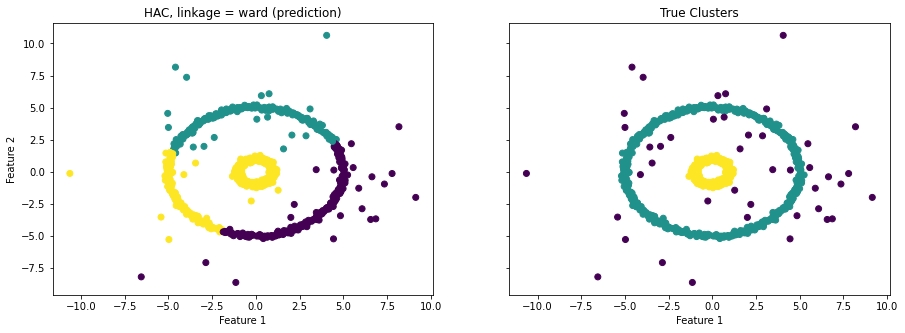

In [21]:
plot_clusters(y, y_pred, 'HAC, linkage = ward')

Τέλος, ο σύνδεσμος ward ενώνει τα clusters έχοντας ως κριτήριο την ελαχιστοποίηση της διακύμανσης των cluster που θα ενωθούν. Απ'όλες τις συνδέσεις η σύνδεση ward είναι αυτή που ερμηνεύει καλύτερα τα δεδομένα όπως φαίνεται και από τις τιμές των τριών μετρικών. Πιο αναλυτικά, αν με $\text{Var}(C)$ συμβολίσουμε τη «διασπορά» του Cluster $C$ το οποίο έχει $x_1,\dots,x_n$ δείγματα, δηλαδή
$$\text{Var}(C)=\sum_{i=1}^{n}||x_i - \bar{x}||_2^2$$,
όπου $\bar{x}$ ο μέσος όρος των $x_i$, τότε το κριτήριο με το οποίο γίνεται η σύνδεση δύο Cluster $C_1,\,C_2$ είναι η ελαχιστοποίησης της ποσότητας
$$D(C_1,\,C_2) = \text{Var}(C_1\cup C_2) - \text{Var}(C_1)-\text{Var}(C_2).$$
Δηλαδή, τα Cluster $C_1,\,C_2$ ενώνονται μεταξύ τους αν και μόνο αν 
$$D(C_1,\,C_2)\leq D(C_1,\,C_j),\quad \text{για κάθε}\, j\neq 1,2.$$

# 1.3 Implementation of GMM

In [22]:
# Υλοποίηση του GMM
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=num_clusters)

results, y_pred = evaluate_metrics(model, X, y, num_clusters, model_name = 'GMM')

In [23]:
# Update our DataFrame with results

result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898
0,"HAC, linkage=complete",0.33031,0.35743,0.35901,0.002001
0,"HAC, linkage=ward",0.42839,0.4357,0.43692,0.003011
0,GMM,0.05085,0.17319,0.1756,0.039001


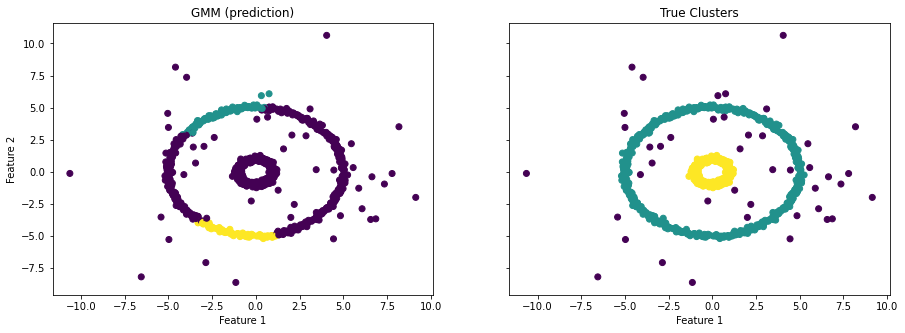

In [24]:
plot_clusters(y,y_pred, model_name = 'GMM')

# 1.4 Implementation of DBSCAN & HDBSCAN

Απ'τα παραπάνω διαγράμματα διασποράς παρατηρούμε πως τα δεδομένα διαμορφώνουν ουσιαστικά δύο Clusters και το τρίτο Cluster αντιπροσωπεύει τον θόρυβο που έχει υπυσέλθει στα δεδομένα. Όλοι οι προηγούμενοι αλγόριθμοι δεν μπορούσαν να εντοπίσουν αυτόν τον θόρυβο. Οι αλγόριθμοι DBSCAN και HDBSCAN είναι δύο αλγόριθμοι που μπορούν να εντοπίσουν τον θόρυβο που έχει υπυσέλθει στα δεδομένα συνεπώς αναμένουμε τα αποτελέσματα γι'αυτούς τους δύο να είναι πολύ «κοντά» στο πραγματικό.

# 1.4.1 DBSCAN

In [25]:
from sklearn.cluster import DBSCAN

start_time = time.time()
model = DBSCAN(eps=1, min_samples=10).fit(X)
y_pred = model.labels_
end_time = round(time.time() - start_time,6) # Time of fit and Predict

results = ['DBSCAN', round(metrics.adjusted_rand_score(y, y_pred),5),
          round(metrics.adjusted_mutual_info_score(y, y_pred),5),
          round(metrics.v_measure_score(y, y_pred),5), end_time] 


# Update our DataFrame with results

result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898
0,"HAC, linkage=complete",0.33031,0.35743,0.35901,0.002001
0,"HAC, linkage=ward",0.42839,0.4357,0.43692,0.003011
0,GMM,0.05085,0.17319,0.1756,0.039001
0,DBSCAN,0.96705,0.93468,0.93484,0.004922


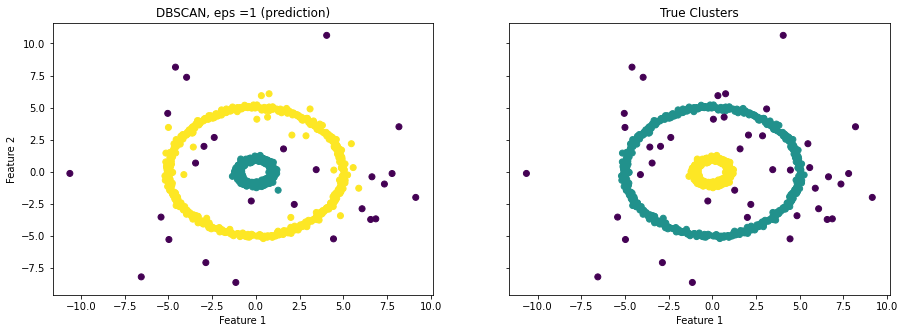

In [26]:
plot_clusters(y, y_pred, model_name = 'DBSCAN, eps =1')

Όπως φαίνεται και απ'τα παραπάνω διαγράμματα διασποράς ο DBSCAN έχει εντοπίσει σχεδόν με απόλυτη ακρίβεια τον θόρυβο που έχει υπυσέλθει στα δεδομένα. Αν ελαττώσουμε και άλλο την παράμετρο «eps», που είναι η μέγιστη απόσταση μεταξύ ενός Cluster και ενός σημείου ώστε το σημείο να ενταχθεί στο Cluster, αναμένουμε να έχουμε καλύτερη ακρίβεια. Αυτό φαίνεται και απ'τα αποτελέσματα παρακάτω.

In [27]:
start_time = time.time()
model = DBSCAN(eps=0.5, min_samples=10).fit(X) # Set eps = 0.5
y_pred = model.labels_
end_time = round(time.time() - start_time,6) # Time of fit and Predict

results = ['DBSCAN, eps =0.5', round(metrics.adjusted_rand_score(y, y_pred),5),
          round(metrics.adjusted_mutual_info_score(y, y_pred),5),
          round(metrics.v_measure_score(y, y_pred),5), end_time]

print(results)

['DBSCAN, eps =0.5', 0.998, 0.99315, 0.99317, 0.007998]


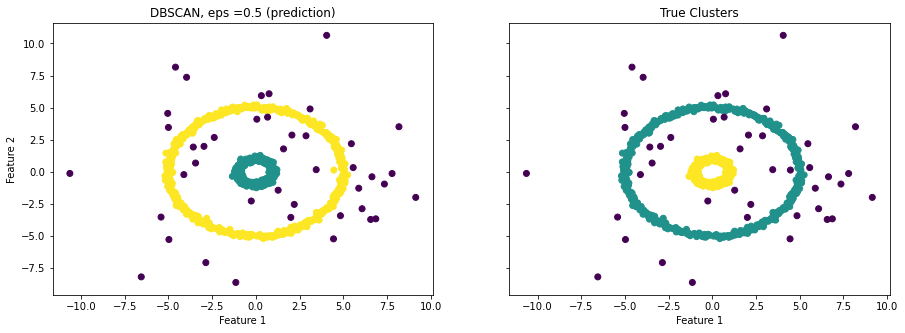

In [28]:
plot_clusters(y, y_pred, model_name = 'DBSCAN, eps =0.5')

Όπως φαίνεται και απ'τα παραπάνω διαγράμματα διασποράς ο DBSCAN με epsilon = 0.5 αποκωδικοποιεί πλήρως τη δομή των δεδομένων. (Για την ακρίβεια ξεφεύγει μόνο ένα σημείο αλλά με κατάλληλη μείωση του epsilon μπορούμε να το βάλουμε και αυτό στο Cluster του θορύβου).

In [29]:
# Ανανεώνουμε τα δεδομένα
results[0] = 'DBSCAN'
result_small.iloc[6,:] = pd.Series(results)

# Updated results
result_small

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898
0,"HAC, linkage=complete",0.33031,0.35743,0.35901,0.002001
0,"HAC, linkage=ward",0.42839,0.4357,0.43692,0.003011
0,GMM,0.05085,0.17319,0.1756,0.039001
0,DBSCAN,0.998,0.99315,0.99317,0.007998


# 1.4.2 HDBSCAN

In [30]:
# Υλοποίηση του HDBSCAN
import hdbscan

start_time = time.time()
y_pred = hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(X)
end_time = round(time.time()-start_time,6)

results = ['HDBSCAN', round(metrics.adjusted_rand_score(y, y_pred),5),
          round(metrics.adjusted_mutual_info_score(y, y_pred),5),
          round(metrics.v_measure_score(y, y_pred),5), end_time]

print(results)

['HDBSCAN', 0.95763, 0.916, 0.91621, 0.019998]


In [31]:
# Update our DataFrame with results

result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898
0,"HAC, linkage=complete",0.33031,0.35743,0.35901,0.002001
0,"HAC, linkage=ward",0.42839,0.4357,0.43692,0.003011
0,GMM,0.05085,0.17319,0.1756,0.039001
0,DBSCAN,0.998,0.99315,0.99317,0.007998
0,HDBSCAN,0.95763,0.916,0.91621,0.019998


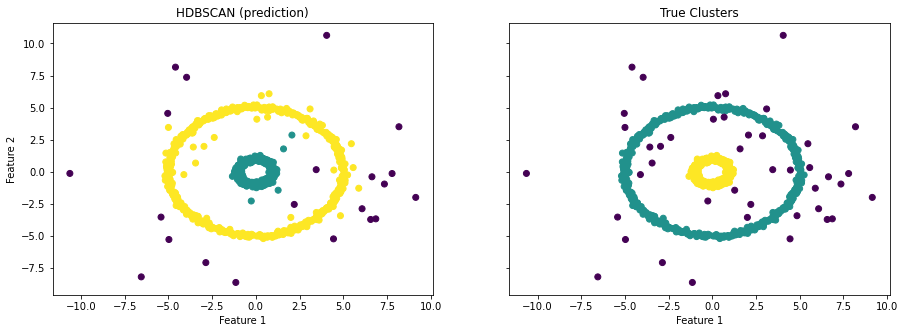

In [32]:
plot_clusters(y, y_pred, model_name = 'HDBSCAN')

Όπως και στην περίπτωση του DBSCAN βλέπουμε ότι και ο HDBSCAN έχει απομονώσει τον θόρυβο που υπάρχει στα δεδομένα και τον έχει ξεχωρίσει απ'τα άλλα δύο Clusters.

# 1.5 Implementation of SOM

In [33]:
# clustering with som

from sklearn_som.som import SOM

model = SOM(m=3, n=1, dim=2)
results, y_pred = evaluate_metrics(model, X, y, num_clusters, model_name='SOM')

# Update our DataFrame with results

result_small = pd.concat([result_small, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_small # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,0.3262,0.36275,0.36418,0.078125
0,"HAC, linkage=single",0.00596,0.0107,0.01441,0.003001
0,"HAC, linkage=average",0.00895,0.01768,0.02153,0.002898
0,"HAC, linkage=complete",0.33031,0.35743,0.35901,0.002001
0,"HAC, linkage=ward",0.42839,0.4357,0.43692,0.003011
0,GMM,0.05085,0.17319,0.1756,0.039001
0,DBSCAN,0.998,0.99315,0.99317,0.007998
0,HDBSCAN,0.95763,0.916,0.91621,0.019998
0,SOM,0.22127,0.17469,0.17635,0.121904


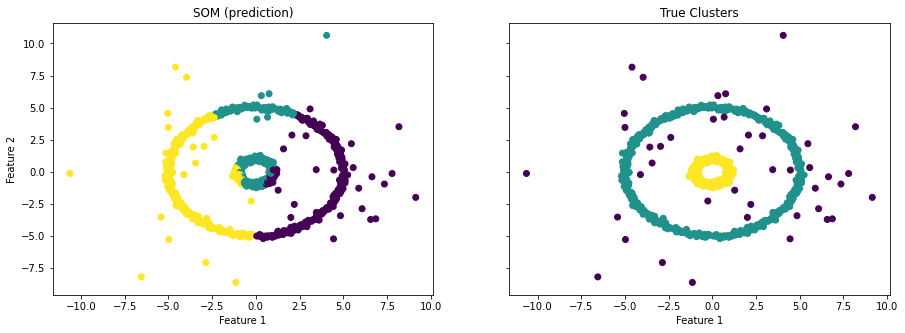

In [34]:
plot_clusters(y, y_pred, model_name = 'SOM')

# 1.6 Αποτελέσματα και συμπεράσματα

Στον παρακάτω πίνακα βλέπουμε την επίδοση του κάθε αλγορίθμου ως προς τις τρεις μετρικές AdjustedRandIndex, AdjustedMutualInformation και V-measure.

| **Αλγόριθμος** | **AdjustedRandIndex**|**AdjustedMutualInformation**|**V-measure**|**Time (sec)**|
|:---------------|:-----------------|:---------------|:---------------|:---------------|
**KMeans**|0.3262	|0.36275	|0.36418|0.078125|
|**HAC, linkage=single**|0.00596|0.0107|0.01441|0.001999|
|**HAC, linkage=average**|0.00895|0.01768|0.02153|0.003007|
|**HAC, linkage=complete**|0.33031|0.35743|0.35901|0.002001|
|**HAC, linkage=ward**|0.42839|0.4357|0.43692|0.003011|
|**GMM**|0.40596|0.418|0.41927|0.024996|
|**DBSCAN**|0.998|0.99315|0.99317|0.007999|
|**HDBSCAN**|0.95763|0.916|0.91621|0.019995|
|**SOM**|	0.19666	|0.22379	|0.22536|	0.129582|


Απ' τον παραπάνω πίνακα παρατηρούμε πως την καλύτερη επίδοση και ως προς τις τρεις μετρικές την έχει ο DBSCAN και δεύτερος έρχεται ο HDBSCAN. Τη χαμηλοτέρη επίδοση και ως προς τις τρεις μετρικές έχει ο ιεραρχικός συσσωρευτικός αλγόριθμος με σύνδεση single, δηλαδή οι συστάδες που δημιουργούνται ακολουθώντας τη διαδικασία bottom - up γίνονται με βάση με την ελάχιστη απόσταση μεταξύ δύο σημείων της κάθε συστάδας. Όπως αναφέραμε και προηγούμενως οι καλύτεροι αλγόριθμοι για το συγκεκριμένο σύνολο δεδομένων είναι ο DBSCAN και ο HDBSCAN γιατί λαμβάνουν υπ'όψιν τον θόρυβο που έχει υπυσέλθει στα δεδομένα καθώς και το ότι τα σύνολα που σχηματίζονται απ'τις συστάδες είναι μη κυρτά υποσύνολα του $\mathbb{R^2}$.

Παρακάτω βλέπουμε τους πίνακες σύγχυσης για τον καλύτερο αλγόριθμο για το πρόβλημα (DBSCAN) και τον χειρότερο (HAC με σύνδεση single).

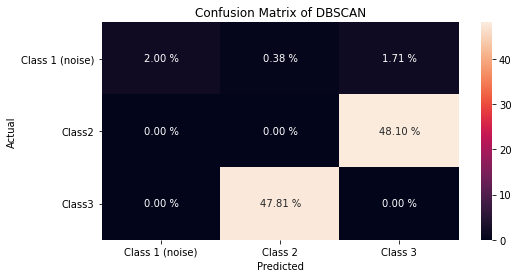

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(X)
cf_matrix = confusion_matrix(y, y_pred)

cf_df = pd.DataFrame(cf_matrix, index = ['Class 1 (noise)' ,'Class2', 'Class3'],
                    columns = ['Class 1 (noise)', 'Class 2', 'Class 3'])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
res = sns.heatmap(100*cf_df/cf_matrix.sum(), annot=True, fmt='.2f')
for t in res.texts: t.set_text(t.get_text() + " %")
plt.title('Confusion Matrix of DBSCAN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

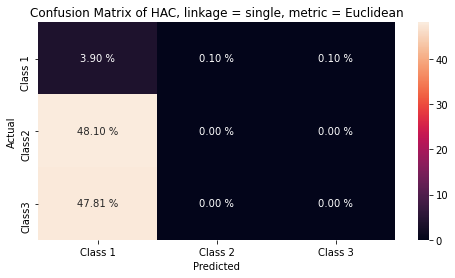

In [36]:
# Confusion matrix for the worst model - HAC with linkage = single

worst_model = fastcluster.linkage(X, method = 'single')
y_pred = fcluster(worst_model, num_clusters, criterion='maxclust')

cf_matrix = confusion_matrix(y, y_pred-2)

cf_df = pd.DataFrame(cf_matrix, index = ['Class 1' ,'Class2', 'Class3'],
                    columns = ['Class 1', 'Class 2', 'Class 3'])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
res = sns.heatmap(100*cf_df/cf_matrix.sum(), annot=True, fmt='.2f')
for t in res.texts: t.set_text(t.get_text() + " %")
plt.title('Confusion Matrix of HAC, linkage = single, metric = Euclidean')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Μέρος 2ο - Μεγάλο Dataset

In [37]:
# Φορτώνουμε τα δεδομένα του μεγάλου dataset

import numpy as np

github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"

dataset = "h2mg/h2mg_128_70" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels1.gz"

!wget $data_url
!wget $labels_url

# load data into a numpy array
X = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)

# Load the corresponding reference labels. The original labels are in {1,2,..,k}.
# We'll make them more Python-ish by subtracting 1.
y  = np.loadtxt(dataset.split("/")[1]+".labels1.gz", dtype=np.intc)-1

# The number of unique labels gives the true cluster count:
num_clusters = len(np.unique(y))

--2021-12-19 16:35:28--  https://github.com/gagolews/clustering_benchmarks_v1/raw/master/h2mg/h2mg_128_70.data.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/h2mg/h2mg_128_70.data.gz [following]
--2021-12-19 16:35:29--  https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/h2mg/h2mg_128_70.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484495 (473K) [application/octet-stream]
Saving to: 'h2mg_128_70.data.gz.27'

     0K .......... .......... .......... .......... .......... 10%  654K 1s
    50K .......... .......... .....

In [38]:
# Οι διαστάσεις των δεδομένων και τα Clusters

print('The dimensions of the small dataset are: ', X.shape)
print('The unique clusters are:', num_clusters)

The dimensions of the small dataset are:  (2048, 128)
The unique clusters are: 2


In [39]:
print(X) # Ο πίνακας με τα χαρακτηριστικά

print(f'\n- Largest value: {X.max()}, Minimum value: {X.min()}')

[[1326. -259.  285. ...  706. -118.  120.]
 [ 916.    5. -375. ... -985. 1152.  429.]
 [ 636.  527.  507. ...  268.  199.  297.]
 ...
 [ 330.  117. -234. ... -578.  468.  948.]
 [ 680.   70.  469. ...  152.  637.  891.]
 [ 670.  446. 1277. ...  598.  721.  801.]]

- Largest value: 10030.0, Minimum value: -7686.0


Παρακάτω θα προσπαθήσουμε μια εποπτεία των δεδομένων προβαλλοντάς τα με PCA στις 2 και στις 3 διαστάσεις.

[]

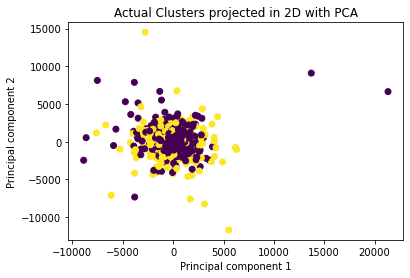

In [40]:
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

X2 = PCA(n_components = 2).fit_transform(X)

plt.scatter(X2[:,0], X2[:,1], c = y)
plt.title('Actual Clusters projected in 2D with PCA')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()

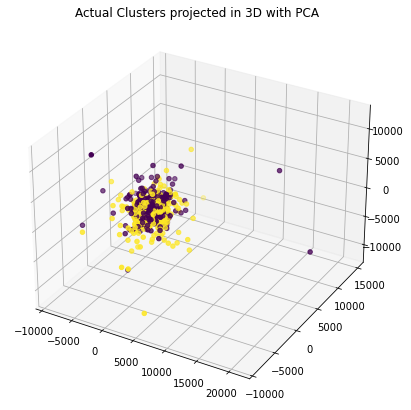

In [41]:
X3 = PCA(n_components =3).fit_transform(X)

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], c = y)
plt.title('Actual Clusters projected in 3D with PCA')
plt.show()

Όπως βλέπουμε οι τιμές των δεδομένων μας έχουν μεγάλες αποκλίσεις γι'αυτό το λόγω κανονικοποιούμε τα δεδομένα

In [42]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

# Scaled data
print(X_scaled)

[[ 0.95595143 -0.99054898 -0.34211827 ...  0.17934487 -0.89073692
  -0.6086233 ]
 [ 0.4522824  -0.66514469 -1.16166256 ... -1.90270122  0.72899535
  -0.20366665]
 [ 0.10831331 -0.02173166 -0.06645337 ... -0.35994324 -0.48644154
  -0.37665784]
 ...
 [-0.26759576 -0.52709438 -0.98657809 ... -1.40158191 -0.14336439
   0.47650328]
 [ 0.1623656  -0.58502621 -0.11363925 ... -0.5027684   0.07217479
   0.40180253]
 [ 0.15008099 -0.12157161  0.88968163 ...  0.04636972  0.17930668
   0.28385399]]


[]

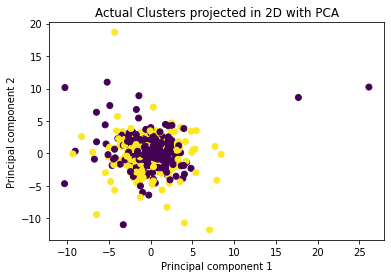

In [43]:
# Απεικονίζουμε πάλι τα δεδομένα στις 2 και 3 διαστάσεις
# μετά απ'την κανονικοποίηση

X2 = PCA(n_components = 2).fit_transform(X_scaled)

plt.scatter(X2[:,0], X2[:,1], c = y)
plt.title('Actual Clusters projected in 2D with PCA')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()


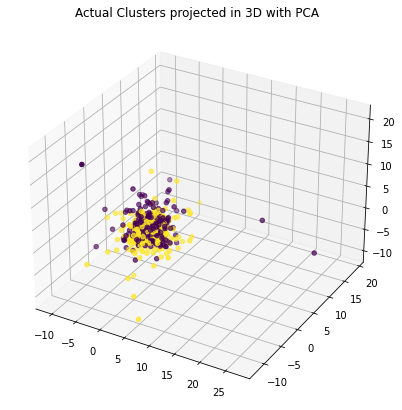

In [44]:
X3 = PCA(n_components =3).fit_transform(X_scaled)

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], c = y)
plt.title('Actual Clusters projected in 3D with PCA')
plt.show()

Απ'τα παραπάνω διαγράμματα διασποράς δε μπορούμε να διακρίνουμε κάποια ιδιαίτερη δομή των δεδομένων. Προχωράμε με την υλοποίηση των αλγορίθμων όπως κάναμε και στο 1ο Μέρος.

# 2.1 KMeans Implementation

In [45]:
# Εφαρμόζουμε τον KMeans πάνω στα δεδομένα

model = KMeans(n_clusters = num_clusters, n_init = 50, max_iter=600)

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'KMeans') # Υπολογίζουμε χρόνους και μετρικές
print('Results:', results)

Results: ['KMeans', 8e-05, -0.00032, 0.00018, 0.510171]


Παρακάτω βλέπουμε ότι ο KMeans δίνει τελείως διαφορετικά αποτελέσματα για διάφορα random states. Αυτό δείχνει ότι ο συγκεκριμένος αλγόριθμος δε μπορεί να θεωρηθεί αξιόπιστος για το συγκεκριμένο πρόβλημα

In [46]:
import random

# Κάνουμε 5 εκτελέσεις του KMeans
print('             ARI       AMI     Vm     Time')
for i in range(5):
    random.seed() # set random seed
    random_state = random.randint(1, 1e+4)
    model = KMeans(n_clusters = num_clusters, random_state = random_state)
    print(evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'KMeans')[0])

             ARI       AMI     Vm     Time
['KMeans', 0.08432, 0.09725, 0.09761, 0.064]
['KMeans', -0.00021, -0.00046, 6e-05, 0.064768]
['KMeans', -0.0002, 0.00058, 0.00103, 0.075969]
['KMeans', 0.00096, 0.00364, 0.00409, 0.069289]
['KMeans', 0.00475, 0.01458, 0.01503, 0.078123]


Φυσικά, γνωρίζοντας εκ των προτέρων τα πραγματικά labels των δεδομένων μπορούμε να «κλέψουμε» αρχικοποιώντας τα κέντρα του KMeans να είναι τα κέντρα των δύο Cluster που έχουμε. Παρακάτω βλέπουμε την επίδοση αυτού του «πειραγμένου» KMeans.

In [47]:
center_1 = X_scaled[y == 0,:].mean(axis=0) # Center for class 1
center_2 = X_scaled[y == 1,:].mean(axis=0) # Center for class 2

model = KMeans(n_clusters = num_clusters, init = np.vstack([center_1.T, center_2.T])) # initialize with center1, center2

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'KMeans')

print(f"- The metrics for biased KMeans are:\n- Adjusted Rand Index: {results[1]:.3f}\n- Adjusted Mutual Information: {results[2]:.3f}\n- V-measure: {results[3]:.3f}")

- The metrics for biased KMeans are:
- Adjusted Rand Index: 0.825
- Adjusted Mutual Information: 0.731
- V-measure: 0.731


C:\Users\dem0nakos\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [48]:
# Τρέχουμε για άλλη μια φορά μια τυχαία εκτέλεση και
# αποθηκεύουμε το αποτέλεσμα

model = KMeans(n_clusters = num_clusters, n_init = 50, max_iter=600, random_state =10)

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'KMeans') # Υπολογίζουμε χρόνους και μετρικές

# Φτιάχνουμε ένα DataFrame για τα δεδομένα

result_big = pd.DataFrame(results, index =['Algorithm', 'AdjustedRandIndex', 'AMInformation', 'V-measure', 'Time']).T

result_big

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312


# 2.2 HAC Implementation

# 2.2.1 Σύνδεσμος 'single'

In [49]:
# Υλοποίηση HAC με linkage = single
import fastcluster 

model = fastcluster.linkage(X_scaled, method = 'single') # HAC with linkage = 'single'

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'HAC', linkage = 'single')

result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])
result_big

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0


[]

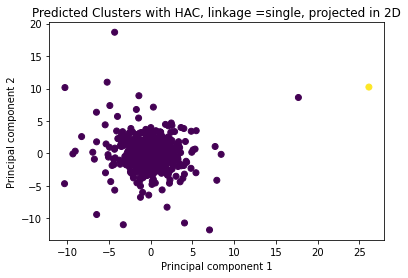

In [50]:
# Τα clusters που σχηματίζονται στις δύο διαστάσεις απ'τον HAC
# με σύνδεσμο single

plt.scatter(X2[:,0], X2[:,1], c = y_pred)
plt.title('Predicted Clusters with HAC, linkage =single, projected in 2D')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()

# 2.2.2 Σύνδεσμος 'average'

In [51]:
# Υλοποίηση HAC με linkage = average
import fastcluster 

model = fastcluster.linkage(X_scaled, method = 'average') # HAC with linkage = 'average'

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'HAC', linkage = 'average')

result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])
result_big

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=average",0.00003,0.00002,0.00099,0.0


[]

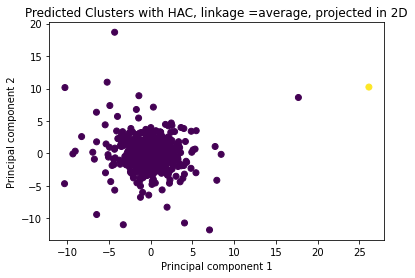

In [52]:
# Τα clusters που σχηματίζονται στις δύο διαστάσεις απ'τον HAC
# με σύνδεσμο average

plt.scatter(X2[:,0], X2[:,1], c = y_pred)
plt.title('Predicted Clusters with HAC, linkage =average, projected in 2D')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()

# 2.2.3 Σύνδεσμος 'complete'

In [53]:
# Υλοποίηση HAC με linkage = complete
import fastcluster 

model = fastcluster.linkage(X_scaled, method = 'complete') # HAC with linkage = 'complete'

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'HAC', linkage = 'complete')

result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])
result_big

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=average",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=complete",0.00003,0.00002,0.00099,0.0


[]

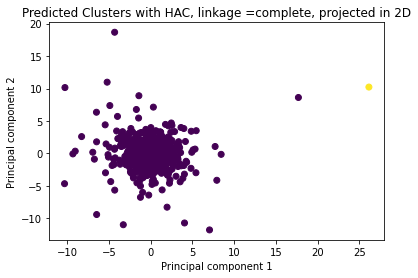

In [54]:
# Τα clusters που σχηματίζονται στις δύο διαστάσεις απ'τον HAC
# με σύνδεσμο complete

plt.scatter(X2[:,0], X2[:,1], c = y_pred)
plt.title('Predicted Clusters with HAC, linkage =complete, projected in 2D')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()

# 2.2.3 Σύνδεσμος 'Ward'

In [55]:
# Υλοποίηση HAC με linkage = ward
import fastcluster 

model = fastcluster.linkage(X_scaled, method = 'complete') # HAC with linkage = 'ward'

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'HAC', linkage = 'ward')

result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])
result_big

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=average",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=complete",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=ward",0.00003,0.00002,0.00099,0.0


[]

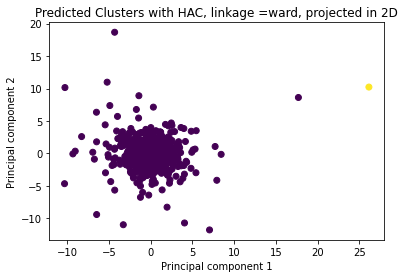

In [56]:
# Τα clusters που σχηματίζονται στις δύο διαστάσεις απ'τον HAC
# με σύνδεσμο ward

plt.scatter(X2[:,0], X2[:,1], c = y_pred)
plt.title('Predicted Clusters with HAC, linkage =ward, projected in 2D')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()

# 2.3 Implementation of GMM

In [57]:
# Υλοποίηση του GMM
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=num_clusters)

results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name = 'GMM')

In [58]:
result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])
result_big

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=average",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=complete",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=ward",0.00003,0.00002,0.00099,0.0
0,GMM,0.00268,0.00444,0.00492,0.133296


# 2.4 Implementation DBSCAN & HDBSCAN

# 2.4.1 DBSCAN

In [59]:
start_time = time.time()
model = DBSCAN(eps=0.8, min_samples=10).fit(X_scaled)
y_pred = model.labels_
end_time = round(time.time() - start_time,6) # Time of fit and Predict

results = ['DBSCAN', round(metrics.adjusted_rand_score(y, y_pred),5),
          round(metrics.adjusted_mutual_info_score(y, y_pred),5),
          round(metrics.v_measure_score(y, y_pred),5), end_time] 


# Update our DataFrame with results

result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_big # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=average",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=complete",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=ward",0.00003,0.00002,0.00099,0.0
0,GMM,0.00268,0.00444,0.00492,0.133296
0,DBSCAN,0.00375,0.0868,0.08773,0.08307


[]

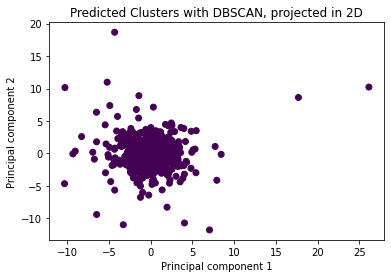

In [60]:
# Τα clusters που σχηματίζονται στις δύο διαστάσεις απ'τον DBSCAN

plt.scatter(X2[:,0], X2[:,1], c = y_pred)
plt.title('Predicted Clusters with DBSCAN, projected in 2D')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()

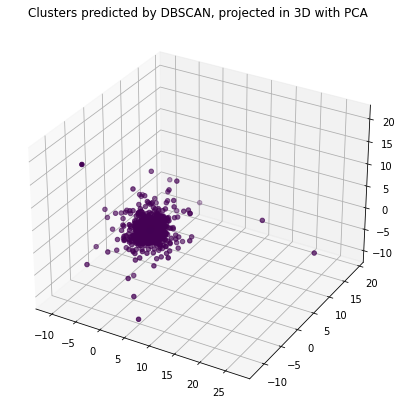

In [61]:
# Και στις τρεις διαστάσεις

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], c = y_pred)
plt.title('Clusters predicted by DBSCAN, projected in 3D with PCA')
plt.show()

In [62]:
# Το πλήθος των σημείων που θεωρούνται ως θόρυβος
# απ'τον DBSCAN

print('- Points considered as noise by DBSCAN:', y_pred[y_pred == -1])
print(f'- They constitute the {100*y_pred[y_pred==-1].shape[0]/X.shape[0]:.3f} % of the dataset')

- Points considered as noise by DBSCAN: [-1 -1 -1 ... -1 -1 -1]
- They constitute the 93.896 % of the dataset


Επομένως βλέπουμε πως ο DBSCAN θεωρεί το 93 % των σημείων ως θόρυβο στα δεδομένα. Αυτό δείχνει πως δε μπορεί να βρει κάποια συσχέτιση μεταξύ των δεδομένων.

# 2.4.2 HDBSCAN

In [63]:
# Υλοποίηση του HDBSCAN
import hdbscan

start_time = time.time()
y_pred = hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(X_scaled)
end_time = round(time.time()-start_time,6)

results = ['HDBSCAN', round(metrics.adjusted_rand_score(y, y_pred),5),
          round(metrics.adjusted_mutual_info_score(y, y_pred),5),
          round(metrics.v_measure_score(y, y_pred),5), end_time]

print(results)

['HDBSCAN', 0.00977, 0.12632, 0.12711, 0.979654]


In [64]:
# Update our DataFrame with results

result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_big # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=average",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=complete",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=ward",0.00003,0.00002,0.00099,0.0
0,GMM,0.00268,0.00444,0.00492,0.133296
0,DBSCAN,0.00375,0.0868,0.08773,0.08307
0,HDBSCAN,0.00977,0.12632,0.12711,0.979654


[]

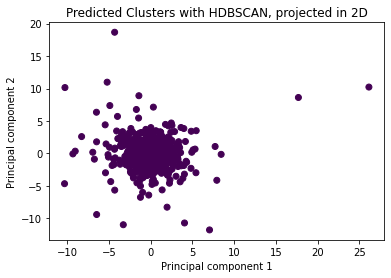

In [65]:
# Τα clusters που σχηματίζονται στις δύο διαστάσεις απ'τον DBSCAN

plt.scatter(X2[:,0], X2[:,1], c = y_pred)
plt.title('Predicted Clusters with HDBSCAN, projected in 2D')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.plot()

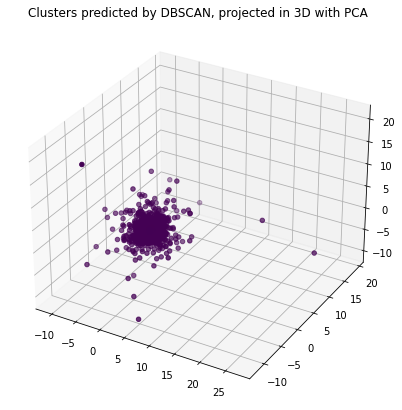

In [66]:
# Και στις τρεις διαστάσεις

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], c = y_pred)
plt.title('Clusters predicted by DBSCAN, projected in 3D with PCA')
plt.show()

# 2.5 Implementation of SOM

In [67]:
# clustering with som

from sklearn_som.som import SOM

model = SOM(m=2, n=128, dim = 128)
results, y_pred = evaluate_metrics(model, X_scaled, y, num_clusters, model_name='SOM')

# Update our DataFrame with results

result_big = pd.concat([result_big, pd.DataFrame(results, index = ['Algorithm',        # Update Results
                                                                      'AdjustedRandIndex',
                                                                       'AMInformation', 'V-measure', 'Time']).T])

result_big # Updated results

,Algorithm,AdjustedRandIndex,AMInformation,V-measure,Time
0,KMeans,-0.00018,0.00088,0.00135,0.274312
0,"HAC, linkage=single",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=average",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=complete",0.00003,0.00002,0.00099,0.0
0,"HAC, linkage=ward",0.00003,0.00002,0.00099,0.0
0,GMM,0.00268,0.00444,0.00492,0.133296
0,DBSCAN,0.00375,0.0868,0.08773,0.08307
0,HDBSCAN,0.00977,0.12632,0.12711,0.979654
0,SOM,0.0023,0.01153,0.03568,4.080899


# 2.6 Αποτελέσματα και συμπεράσματα

Στον παρακάτω πίνακα συνοψίζουμε τα αποτελέσματα των αλγορίθμων.

| **Αλγόριθμος** | **AdjustedRandIndex**|**AdjustedMutualInformation**|**V-measure**|**Time (sec)**|
|:---------------|:-----------------|:---------------|:---------------|:---------------|
**KMeans**|-0.00018		|0.00088	|0.00135|0.274312|
|**HAC, linkage=single**|0.00003|0.00002|0.00099|0.0|
|**HAC, linkage=average**|0.00003|0.00002|0.00099|0.0|
|**HAC, linkage=complete**|0.00003|0.00002|0.00099|0.0|
|**HAC, linkage = ward**|0.00003|0.00002|0.00099|0.0|
|**GMM**|0.00268|0.00444|0.00492|0.133296|
|**DBSCAN**|0.00375|0.0868|0.08773|0.08307|
|**HDBSCAN**|0.0097|0.12632|0.12711|0.979654|
|**SOM**|	0.0023|0.01153	|0.03568|	4.080899|


Σύμφωνα με τον παραπάνω πίνακα βλέπουμε ότι ο καλύτερος αλγόριθμος για το πρόβλημα είναι ο HDBSCAN ενώ αυτοί που έχουν τη χαμηλότερη επίδοση είναι οι αλγόριθμοι HAC και ο GMM. Συνεπώς, ο καλύτερος αλγόριθμος είναι ο HDBSCAN.